# VIX Curve Background

This notebook will be a background on developing a VIX curve carry strategy. 

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.patches import Patch

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/VIXFuturesCurve/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\VIXCurveStrategies\root\src")
from DataCollect import VIXCurveDataCollector

## Exploratory Data Analysis

In [3]:
def get_start_end_date() -> None:

    display(VIXCurveDataCollector().get_vix_curve().drop(
        columns = ["PX_LAST"]).
        groupby("security").
        agg(["min", "max"])
        ["date"].
        rename(columns = {
            "min": "start_date",
            "max": "end_date"}))

get_start_end_date()

,start_date,end_date
security,,
UX1,2004-03-30,2024-10-29
UX2,2004-03-30,2024-10-29
UX3,2004-05-18,2024-10-29
UX4,2004-03-30,2019-12-31
UX5,2004-06-15,2019-12-31


Start by plotting the various VIX futures across the curve.

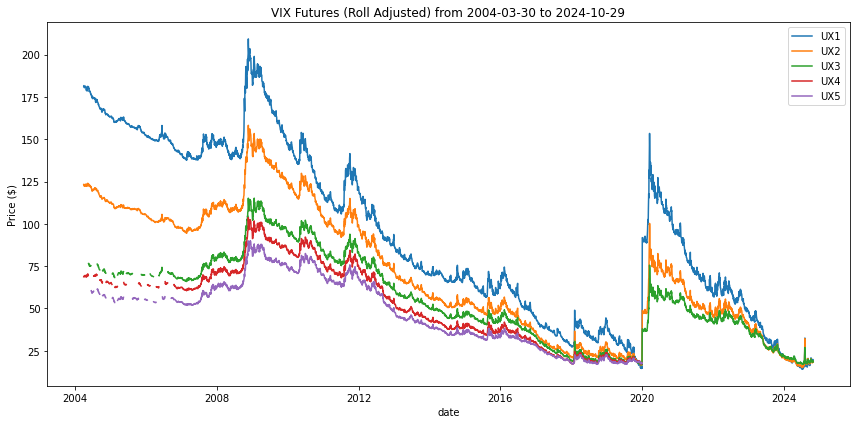

In [4]:
def plot_vix_curve() -> plt.Figure: 

    df_tmp = VIXCurveDataCollector().get_vix_curve()
    
    (df_tmp.rename(
        columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "PX_LAST").
        plot(
            figsize = (12,6),
            ylabel  = "Price ($)",
            title   = "VIX Futures (Roll Adjusted) from {} to {}".format(
                df_tmp.date.min(),
                df_tmp.date.max())))

    plt.tight_layout()

plot_vix_curve()

Now compare the VIX futures contracts, for the most part the contracts are highly correlated. 

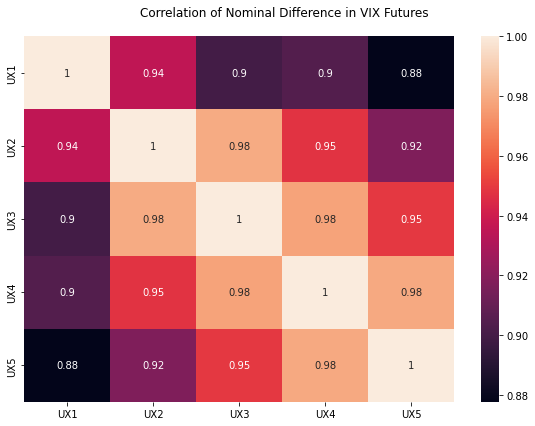

In [5]:
def plot_vix_diff_corr() -> plt.Figure: 

    df_corr = (VIXCurveDataCollector().get_vix_curve().pivot(
        index = "date", columns = "security", values = "PX_LAST").
        diff().
        corr())
    
    fig, axes = plt.subplots(figsize = (8,6))
    sns.heatmap(
        data  = df_corr,
        annot = True)
    
    axes.set_xlabel(""); axes.set_ylabel("")
    fig.suptitle("Correlation of Nominal Difference in VIX Futures")
    plt.tight_layout()

plot_vix_diff_corr()

## Generic Curve Carry

In this case the carrry strategies will be generated using both ```UX1``` and ```UX2``` since some traders use their front contracts for other strategies. In this case using a 50-50 split between each contract generate a L/S spread by always being long the further expiry contracts and short either ```UX1``` or ```UX2```

In [6]:
def get_curve_carry() -> tuple: 

    df_ux1 = (VIXCurveDataCollector().get_vix_curve().pivot(
        index = "date", columns = "security", values = "PX_LAST").
        diff().
        reset_index().
        melt(id_vars = ["date", "UX1"]).
        assign(spread = lambda x: x.value - x.UX1)
        [["date", "security", "spread"]].
        dropna())
    
    df_ux2 = (VIXCurveDataCollector().get_vix_curve().pivot(
        index = "date", columns = "security", values = "PX_LAST").
        diff().
        drop(columns = ["UX1"]).
        reset_index().
        melt(id_vars = ["date", "UX2"]).
        dropna().
        assign(spread = lambda x: x.value - x.UX2)
        [["date", "security", "spread"]])

    return df_ux1, df_ux2

df_ux1, df_ux2 = get_curve_carry()

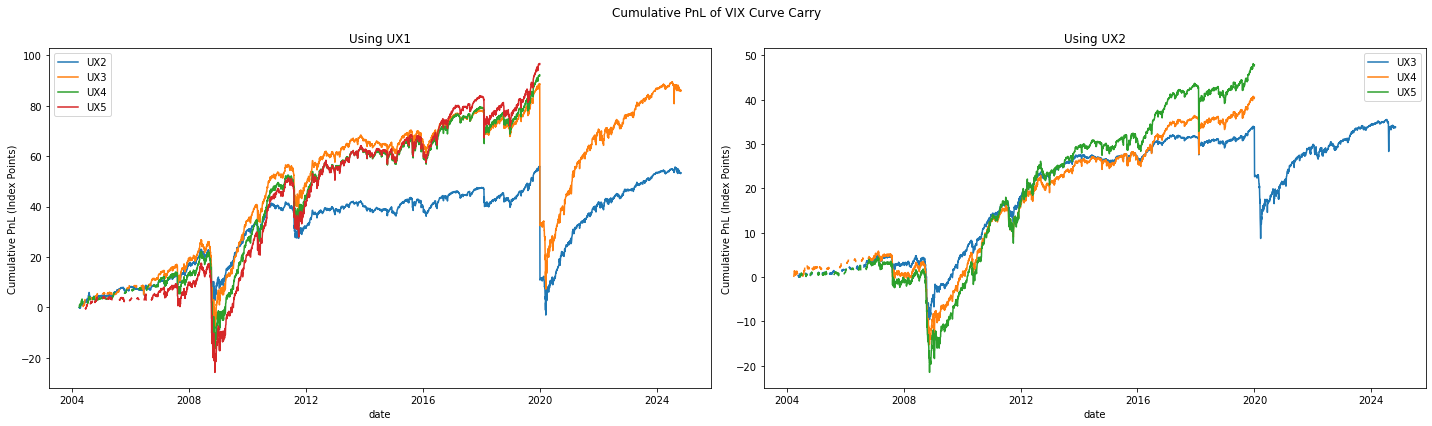

In [7]:
def plot_vix_futures_spread(df_ux1: pd.DataFrame, df_ux2: pd.DataFrame) -> plt.Figure: 
    
    fig, axes = plt.subplots(ncols = 2, figsize = (20,6))

    df_ux1 = (df_ux1.rename(
        columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "spread").
        cumsum())

    df_ux2 = (df_ux2.rename(
        columns = {"security": ""}).
        pivot(index = "date", columns = "", values = "spread").
        cumsum())
    
    df_ux1.plot(
        ax    = axes[0],
        title = "Using UX1")
    
    df_ux2.plot(
        ax    = axes[1],
        title = "Using UX2")
    
    fig.suptitle("Cumulative PnL of VIX Curve Carry")
    for ax in axes.flatten(): ax.set_ylabel("Cumulative PnL (Index Points)")
    plt.tight_layout()

plot_vix_futures_spread(df_ux1, df_ux2)

The strategies have somewhat weaker sharpes and that's also not accounting for the assymetry of returns that occur especially during crisis times.

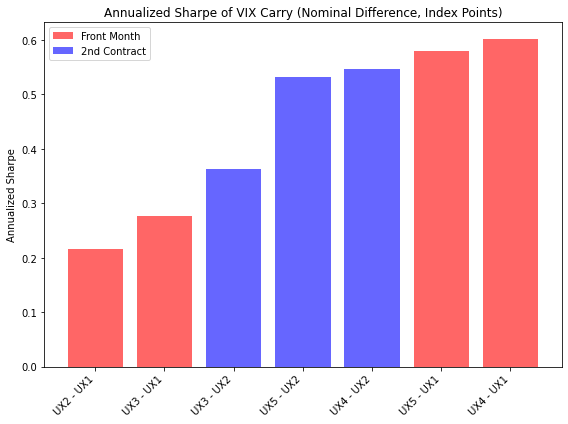

In [8]:
def plot_vix_curve_carry_sharpe(df_ux1: pd.DataFrame, df_ux2: pd.DataFrame) -> plt.Figure: 

    df_ux1_sharpe = (df_ux1.drop(
        columns = ["date"]).
        assign(security = lambda x: x.security + " - UX1").
        groupby("security").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        assign(color = "red"))
    
    df_ux2_sharpe = (df_ux2.drop(
        columns = ["date"]).
        assign(security = lambda x: x.security + " - UX2").
        groupby("security").
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        assign(color = "blue"))
    
    df_sharpes = (pd.concat([
        df_ux1_sharpe, df_ux2_sharpe]).
        sort_values("sharpe"))
    
    fig, ax = plt.subplots(figsize = (8,6))
    
    ax.bar(
        x      = df_sharpes.index, 
        height = df_sharpes["sharpe"], 
        color  = df_sharpes["color"],
        alpha  = 0.6)
    
    ax.set_ylabel("Annualized Sharpe")
    ax.set_title("Annualized Sharpe of VIX Carry (Nominal Difference, Index Points)")
    ax.set_xticks(range(len(df_sharpes.index)))
    ax.set_xticklabels(df_sharpes.index, rotation=45, ha='right')
    
    legend_elements = [
        Patch(facecolor = "Red",  label = "Front Month", alpha = 0.6),
        Patch(facecolor = "Blue", label = "2nd Contract", alpha = 0.6)]
    
    ax.legend(
        handles = legend_elements, 
        loc     = "upper left")
    
    plt.tight_layout()
    plt.show()

plot_vix_curve_carry_sharpe(df_ux1, df_ux2)

## Combining Generic Spreads

In this case start by generating a portfolio using equal risk contribution. 

In [9]:
def _get_std(df: pd.DataFrame, window: int) -> pd.DataFrame: 

    df_out = (df.sort_values(
        "date").
        assign(vol = lambda x: x.spread.rolling(window = window).std().shift()).
        dropna())

    return df_out

def get_erc(df: pd.DataFrame, window: int = 30) -> pd.DataFrame: 

    df_tmp = (df.groupby(
        "security").
        apply(_get_std, window).
        reset_index(drop = True).
        assign(inv_vol = lambda x: 1 / x.vol))
    
    df_out = (df_tmp[
        ["date", "inv_vol"]].
        groupby("date").
        agg("sum").
        rename(columns = {"inv_vol": "cum_vol"}).
        merge(right = df_tmp, how = "inner", on = ["date"]).
        assign(weighted_rtn = lambda x: x.spread * x.inv_vol / x.cum_vol)
        [["date", "weighted_rtn"]].
        groupby("date").
        agg("sum"))

    return df_out

In [10]:
def combine_erc_ports(df_ux1: pd.DataFrame, df_ux2: pd.DataFrame) -> pd.DataFrame: 

    df_out = (get_erc(df_ux1).rename(columns = {
        "weighted_rtn": "UX1 ERC"}).
        merge(right = get_erc(df_ux2), how = "inner", on = ["date"]).
        rename(columns = {"weighted_rtn": "UX2 ERC"}))

    return df_out

df_erc = combine_erc_ports(df_ux1, df_ux2)

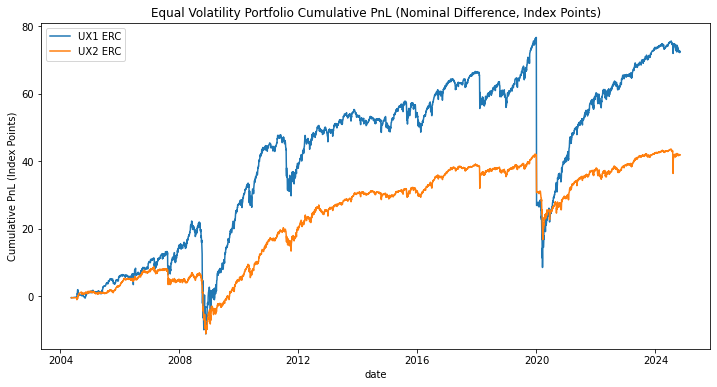

In [11]:
def plot_erc_pnl(df_erc: pd.DataFrame) -> plt.Figure: 

    (df_erc.cumsum().plot(
        ylabel  = "Cumulative PnL (Index Points)",
        figsize = (12,6),
        title   = "Equal Volatility Portfolio Cumulative PnL (Nominal Difference, Index Points)"))

plot_erc_pnl(df_erc)

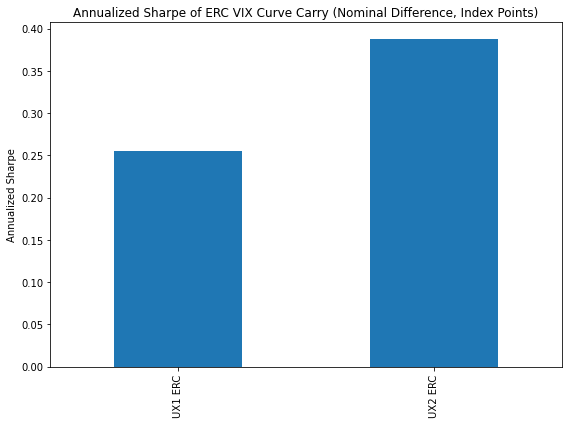

In [12]:
def plot_erc(df_erc: pd.DataFrame) -> plt.Figure: 

    (df_erc.reset_index().melt(
        id_vars = ["date"]).
        drop(columns = ["date"]).
        groupby("variable").
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252))
        [["sharpe"]].
        plot(
            kind    = "bar",
            xlabel  = "",
            ylabel  = "Annualized Sharpe",
            legend  = False,
            figsize = (8,6),
            title   = "Annualized Sharpe of ERC VIX Curve Carry (Nominal Difference, Index Points)"))
    
    plt.tight_layout()

plot_erc(df_erc)

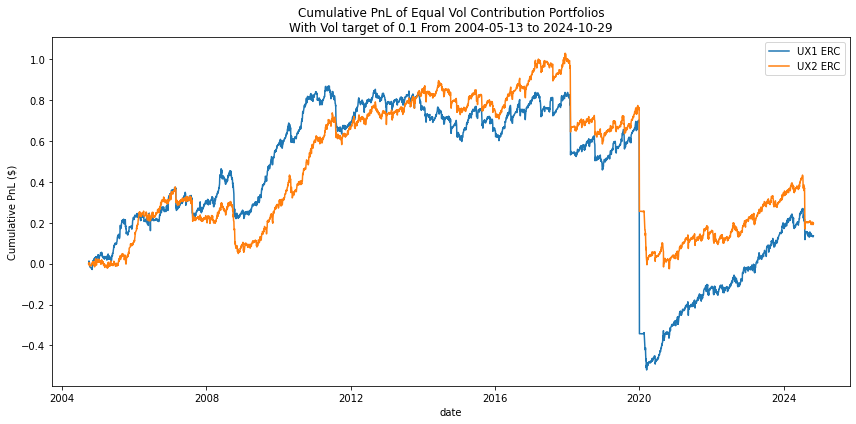

In [13]:
def plot_erc_rtn(df_erc: pd.DataFrame, window: int = 30, target: float = 0.1) -> plt.Figure: 

    (df_erc.reset_index().melt(
        id_vars = "date").
        rename(columns = {"value": "spread"}).
        groupby("variable").
        apply(_get_std, window).
        reset_index(drop = True).
        assign(
            vol          = lambda x: x.vol * np.sqrt(252),
            weight       = lambda x: target / x.vol,
            weighted_rtn = lambda x: x.weight * x.spread)
        [["date", "variable", "weighted_rtn"]].
        rename(columns = {"variable": ""}).
        pivot(index = "date", columns = "", values = "weighted_rtn").
        cumsum().
        plot(
            figsize = (12,6),
            ylabel  = "Cumulative PnL ($)",
            xlabel  = "date",
            title   = "Cumulative PnL of Equal Vol Contribution Portfolios\nWith Vol target of {} From {} to {}".format(
                target,
                df_erc.index.min(),
                df_erc.index.max())))

    plt.tight_layout()
    
plot_erc_rtn(df_erc)